In [1]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
import time

考虑方程:
$$ \frac{\partial  P(t,r)}{\partial t}  
          + \kappa (\theta - r) \frac{\partial P(t,r)}{\partial r}
          + \frac{1}{2} \sigma^2 \frac{\partial^2  P(t,r)}{\partial r^2} - r  P(t,r)  = 0. 
$$
终止时刻有:
$$ P(T,r) = 1. $$
    

使用迎风格式:
\begin{align}
 &\frac{P^{n+1}_{i} -P^{n}_{i}}{\Delta t}  
          + \max \biggl( \kappa(\theta-r_i),\, 0 \biggr) \frac{P^{n}_{i+1} -P^{n}_{i}}{ \Delta r}\\\nonumber 
          &+ \min \biggl( \kappa(\theta-r_i),\, 0 \biggr) \frac{P^{n}_{i} -P^{n}_{i-1}}{ \Delta r} 
          + \frac{1}{2} \sigma^2  \frac{P^{n}_{i+1} + P^{n}_{i-1} - 2 P^{n}_{i}}{\Delta r^2} 
          - r_i  P^{n}_i  = 0. 
\end{align}

边界条件为:
$$ P(t, r_{\text{min}}) = e^{-r_{\text{min}} (T-t)} \quad \text{and} \quad P(t, r_{\text{max}}) = e^{-r_{\text{max}} (T-t)}. $$

于是我们有:
\begin{align}
P_i^{n+1} &= (\frac{\Delta t}{\Delta r}\min - \frac{1}{2}\frac{\Delta t}{\Delta r^2}\sigma^2)P_{i-1}^{n}\\
            &+(\frac{\Delta t}{\Delta r}\max - \frac{\Delta t}{\Delta r}\min +\frac{\Delta t}{\Delta r^2}\sigma^2+r\Delta t+1)P_{i}^{n}\\
            &+(-\frac{\Delta t}{\Delta r}\max - \frac{1}{2}\frac{\Delta t\sigma^2}{\Delta r^2})P_{i+1}^{n}
\end{align}

写成矩阵形式:
$$
A = \begin{bmatrix}
    b    & c    & 0\cdots &0    &0\\
    a    & b    & c\cdots &0    &0\\
    \cdot&\cdot &\cdots   &\cdot&\cdot\\
    \cdot&\cdot &\cdots   &\cdot&\cdot\\
    \cdot&\cdot &\cdots   &\cdot&\cdot\\
    0    & 0    &0\cdots  &a    &b
\end{bmatrix}
$$
$$
AP^{n} = \begin{bmatrix}
&P_1^{n+1} - P_0^na\\
&P_2^{n+1}\\
&\cdot\\
&\cdot\\
&\cdot\\
&P_{J-1}^{n+1}-P_{J}^{n}c
\end{bmatrix}
$$

In [84]:
sigma = 0.5
kappa = 3
theta = 0.5

In [85]:
Nr = 6000  
Nt = 6000
t_end = 5  
r_max = 3  
r_min = -0.8  
r, dr = np.linspace(r_min, r_max, Nr, retstep=True)  
t, dt = np.linspace(0, t_end, Nt, retstep=True) 
Payoff = 1  # P(T,r)=1
P = np.zeros((Nr, Nt))
P[:, -1] = Payoff # t=t_end
P[-1, :] = np.exp(-r[-1] * (t_end - t))  # P(r_max,t)
P[0, :] = np.exp(-r[0] * (t_end - t))    # P(r_min,t)

In [86]:
sig2 = sigma * sigma
drr = dr * dr
max_part = np.maximum(kappa * (theta - r[1:-1]), 0)  # upwind positive part
min_part = np.minimum(kappa * (theta - r[1:-1]), 0)  # upwind negative part
a = min_part * (dt / dr) - 0.5 * (dt / drr) * sig2
b = 1 + dt * r[1:-1] + (dt / drr) * sig2 + dt / dr * (max_part - min_part)
c = -max_part * (dt / dr) - 0.5 * (dt / drr) * sig2

In [87]:
a_diag = np.ones((Nr-2,))*b
A_diag = scipy.sparse.spdiags(a_diag, 0, Nr-2, Nr-2)
a_updiag = np.ones((Nr-2,))*c
A_updiag = scipy.sparse.spdiags(np.concatenate((np.array([0]), a_updiag)), 1, Nr-2, Nr-2)
a_offdiag = np.ones((Nr-2,))*a
A_offdiag = scipy.sparse.spdiags(a_offdiag[1:], -1, Nr-2, Nr-2)
A = A_diag+A_offdiag+A_updiag
A = A.tocsc()
offset = np.zeros(Nr - 2)

In [88]:
for n in range(Nt - 2, -1, -1):
    offset[0] = a[0] * P[0, n]
    offset[-1] = c[-1] * P[-1, n]
    P[1:-1, n] = scipy.sparse.linalg.spsolve(A, (P[1:-1, n + 1] - offset))

In [89]:
X0 = 2

In [90]:
result_pde = np.interp(2, r, P[:, 0])
print(result_pde)

0.05303018916704414


显示计算解：
$$ P(t,T) = A(t,T) e^{-B(t,T) r_t} $$

其中

$$ A(t,T) = exp\biggl[ \biggl(\theta - \frac{\sigma^2}{2\kappa^2}\biggr)(B(t,T)-T+t) - \frac{\sigma^2}{4\kappa} B(t,T)^2 \biggr] \quad \text{and} \quad 
B(t,T) = \frac{1}{\kappa} \biggl( 1 - e^{-\kappa (T-t)} \biggr) .$$

In [91]:
B = 1 / kappa * (1 - np.exp(-kappa * t_end))
A = np.exp((theta - sigma**2 / (2 * kappa**2)) * (B - t_end) - sigma**2 / (4 * kappa) * B**2)
result_formula = A * np.exp(-B * 2)
print("Vasicek bond price: ", result_formula)

Vasicek bond price:  0.05299806665958418


https://github.com/cantaro86/Financial-Models-Numerical-Methods/blob/master/2.1%20Black-Scholes%20PDE%20and%20sparse%20matrices.ipynb

考虑BS PDE
$$
\frac{\partial V(t,x)}{\partial t}+\left(r-\frac12\sigma^2\right)\frac{\partial V(t,x)}{\partial x}+\frac12\sigma^2\frac{\partial^2V(t,x)}{\partial x^2}-rV(t,x)=0.
$$
对于这种方程，我们一般知道它终止时刻的解，所以当构造如下格式的时候，我们是已知$V^{n+1}$计算$V^n$

执行价格：K, 终止时间：T

CALL：

终止时刻：
$$
V(T,x) = max(e^x-K,0)
$$

边界条件：
$$
\text{左边界:}\quad V(t,x)\operatorname*{=}_{x\to-\infty}0\quad \text{右边界:}\quad V(t,x)\operatorname*{\sim}_{x\to\infty}e^x-Ke^{-r(T-t)}
$$

离散格式：
$$
\frac{V_i^{n+1}-V_i^n}{\Delta t}+(r-\frac12\sigma^2)\frac{V_{i+1}^n-V_{i-1}^n}{2\Delta x}+\frac12\sigma^2\frac{V_{i+1}^n+V_{i-1}^n-2V_i^n}{\Delta x^2}-rV_i^n=0.
$$

这个是隐式格式，从$V^{n+1}$计算$V^n$

$$
\begin{aligned}
V_i^{n+1}& =V_i^n\left(1+r\Delta t+\sigma^2\frac{\Delta t}{\Delta x^2}\right)  \\
&+V_{i+1}^n\left(-(r-\frac12\sigma^2)\frac{\Delta t}{2\Delta x}-\frac12\sigma^2\frac{\Delta t}{\Delta x^2}\right) \\
&+V_{i-1}^n\bigg((r-\frac12\sigma^2)\frac{\Delta t}{2\Delta x}-\frac12\sigma^2\frac{\Delta t}{\Delta x^2}\bigg).
\end{aligned}
$$
可以改写成：
$$
V_i^{n+1}=aV_{i-1}^n+bV_i^n+cV_{i+1}^n,
$$
我们把它用矩阵的形式写出来：
$$
\begin{pmatrix}V_1^{n+1}\\V_2^{n+1}\\\vdots\\V_{M-2}^{n+1}\\V_{M-1}\end{pmatrix}=\underbrace{\begin{pmatrix}b&c&0&\cdots&0\\a&b&c&0&0\\0&\ddots&\ddots&\ddots&0\\\vdots&0&a&b&c\\0&0&0&a&b\end{pmatrix}}_{\mathcal{D}}\cdot\begin{pmatrix}V_1^n\\V_2^n\\\vdots\\V_{M-2}^n\\V_{M-1}^n\end{pmatrix}+\underbrace{\begin{pmatrix}aV_0^n\\0\\\vdots\\0\\cV_M^n\end{pmatrix}}_{\text{B (boundary terms)}}
$$

区间是：$[t_0, T]\times[A_1,A_2],\quad A_1 = log(K/3),\quad A_2=log(3K)$

In [2]:
r = 0.1
sig = 0.2

K = 100
Texpir = 1
Nspace = 3000  # M space steps
Ntime = 2000  # N time steps

S_max = 3 * float(K)
S_min = float(K) / 3

x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1


x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)  # time discretization
Payoff = np.maximum(np.exp(x) - K, 0)  # Call payoff

V = np.zeros((Nspace, Ntime))  # grid initialization
offset = np.zeros(Nspace - 2)  # vector to be used for the boundary terms

V[:, -1] = Payoff  # terminal conditions
V[-1, :] = np.exp(x_max) - K * np.exp(-r * T[::-1])  # boundary condition
V[0, :] = 0  # boundary condition

# construction of the tri-diagonal matrix D
sig2 = sig * sig
dxx = dx * dx

a = (dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
b = 1 + dt * (sig2 / dxx + r)
c = -(dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)

D = scipy.sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()
# Backward iteration
for i in range(Ntime - 2, -1, -1):
    offset[0] = a * V[0, i]
    offset[-1] = c * V[-1, i]
    V[1:-1, i] = scipy.sparse.spsolve(D, (V[1:-1, i + 1] - offset))

CFL = sig*dt/dx**2
S = np.exp(x)

Text(0, 0.5, 'V')

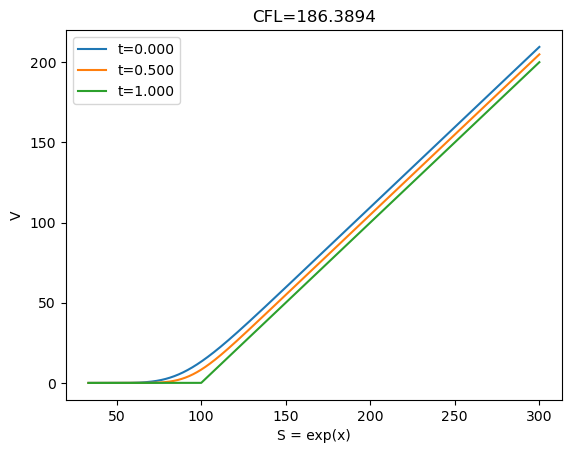

In [3]:
for ti in [1, 1000, 2000]:
    plt.plot(S, V[:,ti-1], label="t=%.3f"%(dt*(ti-1)))
plt.legend()
plt.title("CFL=%.4f"%CFL)
plt.xlabel("S = exp(x)")
plt.ylabel("V")

同样的，这里我们考虑一下显示格式：
$$
\frac{V_i^{n+1}-V_i^n}{\Delta t}+(r-\frac12\sigma^2)\frac{V_{i+1}^{n+1}-V_{i-1}^{n+1}}{2\Delta x}+\frac12\sigma^2\frac{V_{i+1}^{n+1}+V_{i-1}^{n+1}-2V_i^{n+1}}{\Delta x^2}-rV_i^{n+1}=0.
$$
于是有
$$
V_i^n = ((\frac{1}{2}\sigma^2-r)\frac{\Delta t}{2\Delta x}+\frac{\sigma^2\Delta t}{2\Delta x^2})V_{i-1}^{n+1}+(1-\frac{\sigma^2\Delta t}{\Delta x^2}-r\Delta t)V_{i}^{n+1}+((r-\frac{1}{2}\sigma^2)\frac{\Delta t}{2\Delta x}+\frac{\sigma^2\Delta t}{2\Delta x^2})V_{i+1}^{n+1}
$$

注意到边界条件，于是我们有：
$$
V_{0}^{n} = 0\\
V_{-1}^{n} = e^x-Ke^{-r(T-t)}
$$

In [4]:
r = 0.1
sig = 0.2

K = 100
Texpir = 1
Nspace = 300  # M space steps
Ntime = 20000  # N time steps

S_max = 3 * float(K)
S_min = float(K) / 3

x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1


x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)  # time discretization
Payoff = np.maximum(np.exp(x) - K, 0)  # Call payoff

V = np.zeros((Nspace, Ntime))  # grid initialization

V[:, -1] = Payoff  # terminal conditions
V[-1, :] = np.exp(x_max) - K * np.exp(-r * T[::-1])  # boundary condition
V[0, :] = 0  # boundary condition

a1 = (1/2*sig**2-r)*(dt/(2*dx))+sig**2*dt/(2*dx**2)
a2 = 1-sig**2*dt/dx**2-r*dt
a3 = (r-1/2*sig**2)*(dt/(2*dx))+sig**2*dt/(2*dx**2)

CFL = sig*dt/dx**2

In [5]:
for ti in range(Ntime - 2, -1, -1):
    for xi in range(1, Nspace-1):
        V[xi,ti] = a1*V[xi-1,ti+1]+a2*V[xi,ti+1]+a3*V[xi+1,ti+1]

Text(0, 0.5, 'V')

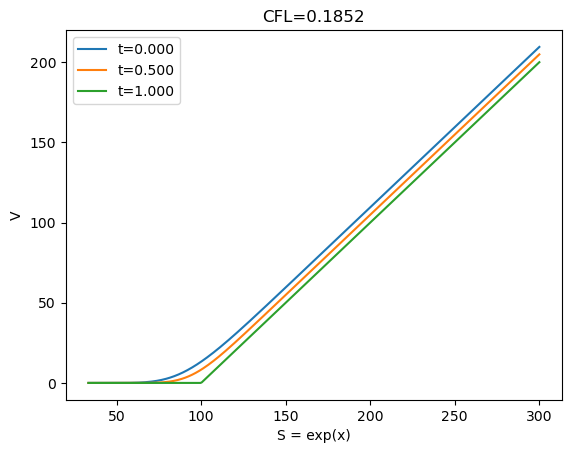

In [6]:
S = np.exp(x)
for ti in [1, 10000, 20000]:
    plt.plot(S, V[:,ti-1], label="t=%.3f"%(dt*(ti-1)))
plt.legend()
plt.title("CFL=%.4f"%CFL)
plt.xlabel("S = exp(x)")
plt.ylabel("V")

In [7]:
r = 0.1
sig = 0.2

K = 100
Texpir = 1
Nspace = 3000  # M space steps
Ntime = 2000  # N time steps

S_max = 3 * float(K)
S_min = float(K) / 3

x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1


x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)  # time discretization
Payoff = np.maximum(np.exp(x) - K, 0)  # Call payoff

V = np.zeros((Nspace, Ntime))  # grid initialization

V[:, -1] = Payoff  # terminal conditions
V[-1, :] = np.exp(x_max) - K * np.exp(-r * T[::-1])  # boundary condition
V[0, :] = 0  # boundary condition

a1 = (1/2*sig**2-r)*(dt/(2*dx))+sig**2*dt/(2*dx**2)
a2 = 1-sig**2*dt/dx**2-r*dt
a3 = (r-1/2*sig**2)*(dt/(2*dx))+sig**2*dt/(2*dx**2)

CFL = sig*dt/dx**2
for ti in range(Ntime - 2, -1, -1):
    for xi in range(1, Nspace-1):
        V[xi,ti] = a1*V[xi-1,ti+1]+a2*V[xi,ti+1]+a3*V[xi+1,ti+1]
S = np.exp(x)

C:\User\Shen\AppData\Local\Temp\ipykernel_16108\4231393499.py:33: RuntimeWarning: overflow encountered in double_scalars
  V[xi,ti] = a1*V[xi-1,ti+1]+a2*V[xi,ti+1]+a3*V[xi+1,ti+1]
C:\User\Shen\AppData\Local\Temp\ipykernel_16108\4231393499.py:33: RuntimeWarning: invalid value encountered in double_scalars
  V[xi,ti] = a1*V[xi-1,ti+1]+a2*V[xi,ti+1]+a3*V[xi+1,ti+1]


Text(0.5, 1.0, 'CFL=186.3894')

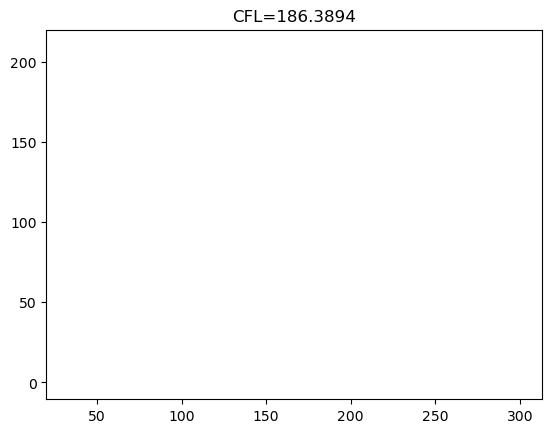

In [8]:
S = np.exp(x)
plt.plot(S, V[:,0])
plt.title("CFL=%.4f"%CFL)

再次说明，显示格式需要CFL条件